# Oil Palm Disease Detection

## Data Acquisition

Data collected from kaggle private dataset. The data was manually selected to 1000 out of a total of about 3000 images each class. Follow these steps:

0. Download the dataset and extract it.
1. Create `data` folder and put the extracted folder in here. `data` folder should now have 1 folder named `selected_dataset` inside.
2. Follow the code.

In [1]:
import os
import shutil

SELECTED_DATA = os.path.join('data', 'selected_dataset')
ORIGINAL_DATA = os.path.join('data', 'cleaned_dataset')
PROCESSED_DATASET = os.path.join('data', 'processed_dataset')
SAMPLE_IMAGE = 'data/selected_dataset/normal/DSC03990_5.JPG'

In [ ]:
def copy_selected(label: str) -> None:
    with open(f'selected_data_{label}.txt', 'r') as f:
        selected_list = [x.strip() for x in f.readlines()]
    for image_file in selected_list:
        src = os.path.join(ORIGINAL_DATA, label, image_file)
        dst = os.path.join(SELECTED_DATA, label, image_file)
        shutil.copyfile(src, dst)


copy_selected('normal')
copy_selected('infected')

## Preprocessing Image

Preprocessing image consist of image enhancing using histogram equalization and noise removal using bilateral smoothing filter.

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from typing import Union
import sys

In [9]:
def enhance(image: Union[str, np.ndarray], display: bool = False) -> np.ndarray:
    """
    Enhance image by using adaptive histogram equalization
    :param display: bool, if true then return converted image in RGB, if not, return as BGR because it needs to continue to another preprocessing
    :param image: [str, np.ndarray], path to image file or image array in numpy array
    :return: np.ndarray, numpy array of enhance image
    """
    if type(image) is str:
        image = cv2.imread(image)
    # convert from BGR to YCrCb
    ycrcb = cv2.cvtColor(image, cv2.COLOR_BGR2YCR_CB)
    # create clahe object
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    # equalize the histogram of the Y channel
    ycrcb[:, :, 0] = clahe.apply(ycrcb[:, :, 0])
    # convert the YCR_CB image back to RGB format
    if display:
        return cv2.cvtColor(ycrcb, cv2.COLOR_YCrCb2RGB)
    else:
        return cv2.cvtColor(ycrcb, cv2.COLOR_YCR_CB2BGR)

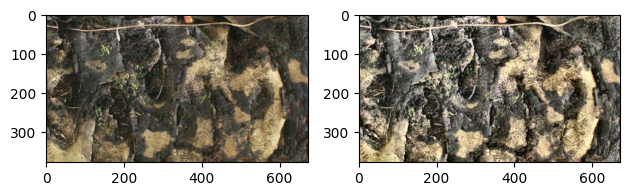

In [10]:
# cv2.imwrite('data/samples/equalized_img.jpg', enhance('data/selected_dataset/normal/DSC03977_4.JPG'))
# cv2.waitKey(0)
def compare_image(image: str, processed_image: np.ndarray):
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(Image.open(image))
    ax[1].imshow(processed_image)
    plt.tight_layout()


compare_image(SAMPLE_IMAGE, enhance(SAMPLE_IMAGE, display=True))

In [11]:
def remove_noise(image: Union[str, np.ndarray], filter: str = 'bilateral', display: bool = False) -> np.ndarray:
    """
    Remove noise from image using bilateral filter
    :param image: [str, np.ndarray], path to image file or image array in numpy array
    :return: np.ndarray, numpy array of image with removed noise
    """
    if type(image) is str:
        image = cv2.imread(image)
    # apply bilateral filter with d = 15, sigmaColor = sigmaSpace = 75.

    if filter == 'bilateral':
        filtered_image = cv2.bilateralFilter(image, 10, 65, 65)
    elif filter == 'median':
        filtered_image = cv2.medianBlur(image, 5)
    else:
        raise ValueError('Unrecognized filter')

    if display:
        return cv2.cvtColor(filtered_image, cv2.COLOR_BGR2RGB)
    return filtered_image

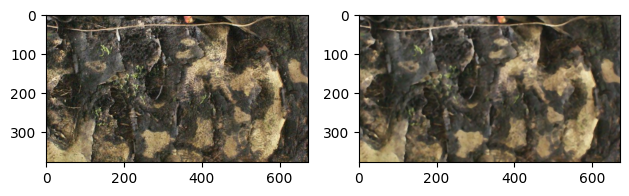

In [12]:
compare_image(SAMPLE_IMAGE, remove_noise(SAMPLE_IMAGE, filter='median', display=True))

In [13]:
def resize(image: Union[str, np.ndarray], size: int = 256) -> np.ndarray:
    """
    Resize image
    :param image: [str, np.ndarray], path to image file or image array in numpy array
    :param size: int, size of image
    :return: np.ndarray, numpy array of image with removed noise
    """
    if type(image) is str:
        image = cv2.imread(image)
    resized_image = cv2.resize(image, (size, size))
    return resized_image

### Apply preprocessing

In [14]:
if not os.path.exists(PROCESSED_DATASET):
    os.makedirs(PROCESSED_DATASET)

for image_class in os.listdir(SELECTED_DATA):
    if not os.path.exists(os.path.join(PROCESSED_DATASET, image_class)):
        os.makedirs(os.path.join(PROCESSED_DATASET, image_class))
    for image_file in os.listdir(os.path.join(SELECTED_DATA, image_class)):
        image_path = os.path.join(SELECTED_DATA, image_class, image_file)
        image = enhance(image_path)
        image = remove_noise(image, filter='median')
        image = resize(image)
        sys.stdout.write(f"\rWriting {image_file} to {PROCESSED_DATASET}")
        sys.stdout.flush()
        cv2.imwrite(os.path.join(PROCESSED_DATASET, image_class, image_file), image)

Writing DSC04873_9.JPG to data\processed_dataset

## Feature Extraction

Feature extraction using LBP, Color moments, and Hu-moments.

In [111]:
import cv2
from skimage import io
from skimage.feature import local_binary_pattern
from skimage.feature import graycomatrix, graycoprops
from skimage.measure import shannon_entropy
import numpy as np
from typing import Union
from scipy.stats import kurtosis, skew
import pandas as pd
import csv


### GLCM

In [13]:
list(range(0, 360, 45))

[0, 45, 90, 135, 180, 225, 270, 315]

In [97]:
def glcm_add_features(glcmatrix: np.ndarray, prop: str):
    add_features_map = {'mean': np.mean,
                        'std': np.std,
                        'entropy': shannon_entropy,
                        'variance': np.var,
                        'kurtosis': kurtosis,
                        'skewness': skew}
    temp_arr = np.zeros((glcmatrix.shape[3],))
    for angle in range(glcmatrix.shape[3]):
        if prop == 'kurtosis' or prop == 'skewness':
            temp_arr[angle] = add_features_map[prop](glcmatrix[:,:,0,angle], axis=None)
        else:
            temp_arr[angle] = add_features_map[prop](glcmatrix[:,:,0,angle])

    return temp_arr

def create_glcm_series(features, angles, props):
    series = pd.Series(np.array(features).ravel(),
                       index=[f'{y}_{x}' for y in props for x in angles])
    return series

In [107]:
def glcm(image: Union[np.ndarray, str]) -> pd.Series:
    """
    Calculate GLCM of an image
    :param image:
    :return:
    """
    angles = [0, 45, 90, 135]
    properties = ['contrast', 'dissimilarity', 'homogeneity', 'ASM', 'energy', 'correlation']
    add_properties = ['mean', 'std', 'entropy', 'variance', 'kurtosis', 'skewness']
    glcm_features = []
    if image is None:
        raise ValueError("image is None")
    if isinstance(image, str):
        image = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
    glcmatrix = graycomatrix(image, distances=[1], angles=angles, normed=True)
    for prop in properties:
        glcm_features.append(graycoprops(glcmatrix, prop)[0])
    for prop in add_properties:
        temp_arr = glcm_add_features(glcmatrix, prop)
        glcm_features.append(temp_arr)

    glcm_series = create_glcm_series(glcm_features, angles, properties+add_properties)

    return glcm_series

glcm(SAMPLE_IMAGE)

contrast_0           2.380511e+02
contrast_45          4.084531e+02
contrast_90          2.295032e+02
contrast_135         2.380511e+02
dissimilarity_0      9.988326e+00
dissimilarity_45     1.325122e+01
dissimilarity_90     9.725902e+00
dissimilarity_135    9.988326e+00
homogeneity_0        1.245942e-01
homogeneity_45       9.644646e-02
homogeneity_90       1.302449e-01
homogeneity_135      1.245942e-01
ASM_0                2.400195e-04
ASM_45               1.857250e-04
ASM_90               2.527668e-04
ASM_135              2.400195e-04
energy_0             1.549256e-02
energy_45            1.362810e-02
energy_90            1.589864e-02
energy_135           1.549256e-02
correlation_0        9.376147e-01
correlation_45       8.929857e-01
correlation_90       9.398401e-01
correlation_135      9.376147e-01
mean_0               1.525879e-05
mean_45              1.525879e-05
mean_90              1.525879e-05
mean_135             1.525879e-05
std_0                5.856259e-05
std_45        

### LBP

In [141]:
def lbp(image: Union[np.ndarray, str], radius: int = 3, n_points: int = 8, methods: str = 'uniform') -> pd.Series:
    """
    Calculate Local Binary Pattern of an image.
    :param image: input image
    :param radius: radius of LBP
    :param n_points: number of points
    :param methods: methods to use for LBP
    :return: LBP histogram
    """
    if image is None:
        raise ValueError("image is None")
    if isinstance(image, str):
        image = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
    lbp = local_binary_pattern(image, n_points, radius, method=methods)
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
    # normalize the histogram
    # hist = hist.astype('float')
    # hist /= (hist.sum() + 1e-7)

    lbp_series = pd.Series(hist.astype('float'),
                           index=[f'lbp_{x}' for x in range(1, len(hist)+1)])
    return lbp_series


lbp(SAMPLE_IMAGE)

lbp_1     20751.0
lbp_2     24686.0
lbp_3     16712.0
lbp_4     17377.0
lbp_5     19412.0
lbp_6     16729.0
lbp_7     16137.0
lbp_8     24458.0
lbp_9     22868.0
lbp_10    74886.0
dtype: float64

### Color Moment

In [140]:
def color_moment(image: Union[np.ndarray, str]) -> pd.Series:
    """
    Calculate color moment of an image (mean, standard deviation, skewness, kurtosis).
    :param image: input image
    :return: color moment
    """
    if image is None:
        raise ValueError("image is None")
    if isinstance(image, str):
        image = io.imread(image)
    # mean of each channel
    mean = np.mean(image, axis=(0, 1))
    # standard deviation of each channel
    std = np.std(image, axis=(0, 1))
    # skewness of each channel
    skewness = np.array([
        skew(image[:,:,0], axis=None),
        skew(image[:,:,1], axis=None),
        skew(image[:,:,2], axis=None)
    ])
    # kurtosis of each channel
    kurt = np.array([
        kurtosis(image[:,:,0], axis=None),
        kurtosis(image[:,:,1], axis=None),
        kurtosis(image[:,:,2], axis=None)
    ])
    color_moment_series = pd.Series(
        np.concatenate((mean, std, skewness, kurt)),
        index=[f'{moment}_{channel}' for channel in ['R', 'G', 'B'] for moment in ['mean', 'std', 'skew', 'kurt']]
    )

    return color_moment_series


color_moment(SAMPLE_IMAGE)

mean_R    92.328987
std_R     83.876531
skew_R    67.206853
kurt_R    49.266753
mean_G    43.049632
std_G     34.402919
skew_G     0.882377
kurt_G     0.958502
mean_B     0.939766
std_B     -0.055151
skew_B     0.297217
kurt_B     0.739102
dtype: float64

### Hu-Moment

In [143]:
def hu_moment(image: Union[np.ndarray, str]) -> pd.Series:
    """
    Calculate Hu moment of an image.
    :param image: input image
    :return: Hu moment
    """
    if image is None:
        raise ValueError("image is None")
    if isinstance(image, str):
        image = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
    # compute moments
    moments = cv2.HuMoments(cv2.moments(image)).flatten()
    hu_moment_series = pd.Series(moments,
                                 index=[f'humoment_{x}' for x in range(len(moments))])
    return hu_moment_series


hu_moment(SAMPLE_IMAGE)

humoment_0    2.303527e-03
humoment_1    1.366589e-06
humoment_2    7.302309e-11
humoment_3    7.990320e-11
humoment_4    4.038724e-21
humoment_5    8.807210e-14
humoment_6   -4.576131e-21
dtype: float64

### Combine all features

In [31]:
def generate_header():
    lbp_columns = [f'lbp_{x}' for x in range(1, 11)]
    color_columns = []
    for moments in ['mean', 'std', 'skew', 'kurt']:
        for color_channel in ['R', 'G', 'B']: color_columns.append(f'{moments}_{color_channel}')
    hu_moment_columns = [f'humoment_{x}' for x in range(1, 8)]
    return ['is_infected'] + lbp_columns + color_columns + hu_moment_columns

In [170]:
_ = pd.concat([glcm(SAMPLE_IMAGE), color_moment(SAMPLE_IMAGE)])
_['is_infected'] = 0
_

contrast_0         238.051124
contrast_45        408.453110
contrast_90        229.503225
contrast_135       238.051124
dissimilarity_0      9.988326
                      ...    
mean_B               0.939766
std_B               -0.055151
skew_B               0.297217
kurt_B               0.739102
is_infected          0.000000
Length: 61, dtype: float64

In [155]:
# pd.DataFrame(glcm(SAMPLE_IMAGE)).transpose()
df = pd.DataFrame(glcm(SAMPLE_IMAGE)).transpose()
pd.concat([df, pd.DataFrame(color_moment(SAMPLE_IMAGE)).transpose()], axis=1)

,contrast_0,contrast_45,contrast_90,contrast_135,dissimilarity_0,dissimilarity_45,dissimilarity_90,dissimilarity_135,homogeneity_0,homogeneity_45,...,skew_R,kurt_R,mean_G,std_G,skew_G,kurt_G,mean_B,std_B,skew_B,kurt_B
0,238.051124,408.45311,229.503225,238.051124,9.988326,13.251222,9.725902,9.988326,0.124594,0.096446,...,67.206853,49.266753,43.049632,34.402919,0.882377,0.958502,0.939766,-0.055151,0.297217,0.739102


In [175]:
# combine all feature
def extract_feature(data_path: str, csv_name: str) -> str:
    """
    Extract feature from images in data_path and save it to csv.
    The extracted feature is texture (LBP), color (color moment), shape (hu-moment)
    :param data_path: str, the path to where the classes folder is
    :param csv_name: str, the name of the csv file
    :return: str, path to csv file containing extracted feature of all image
    """
    df = pd.DataFrame()

    class_map = {'infected': 1, 'normal': 0}
    for image_class in os.listdir(os.path.join(data_path)):
        for image_file in os.listdir(os.path.join(data_path, image_class)):
            image_path = os.path.join(data_path, image_class, image_file)
            # extracted_lbp = lbp(image_path)
            extracted_glcm = glcm(image_path)
            extracted_color_moment = color_moment(image_path)
            extracted_humoment = hu_moment(image_path)
            series_concat = pd.concat([extracted_glcm,
                                       extracted_color_moment,
                                       extracted_humoment])
            series_concat['is_infected'] = class_map[image_class]

            if not df.shape[0]:
                df = pd.DataFrame(series_concat).transpose()
                continue

            df.loc[len(df)] = series_concat

    df.to_csv(os.path.join('data', f'{csv_name}.csv'), index=False)
    df.to_excel(os.path.join('data', 'excel', f'{csv_name}.xlsx'), index=False)

    return df

In [176]:
processed_img_feature = extract_feature(PROCESSED_DATASET, 'processed_img_feature')
orig_img_feature = extract_feature(SELECTED_DATA, 'orig_img_feature')

## Feature Selection

The final feature which will be classified later for comparison is following this pattern.

- Color
- Texture
- Shape
- Color-texture
- Color-shape
- Texture-shape
- Color-texture-shape
- Color-texture-shape (feature selection)

Therefore, we apply feature selection only on the whole feature set. The feature selection method consist of.

- PCA
- Mutual Information
- SelectFromModel

In [181]:
import pandas as pd
import os
import numpy as np
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_classif
from sklearn import svm
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt

In [178]:
proc_img_df = pd.read_csv(os.path.join('data', 'processed_img_feature.csv'))
orig_img_df = pd.read_csv(os.path.join('data', 'orig_img_feature.csv'))

orig_img_df.head(2)

,contrast_0,contrast_45,contrast_90,contrast_135,dissimilarity_0,dissimilarity_45,dissimilarity_90,dissimilarity_135,homogeneity_0,homogeneity_45,...,skew_B,kurt_B,humoment_0,humoment_1,humoment_2,humoment_3,humoment_4,humoment_5,humoment_6,is_infected
0,91.509285,182.967276,126.157904,91.509285,6.014115,8.516554,6.944171,6.014115,0.187917,0.138517,...,1.980106,3.299500,0.002660,0.000002,5.056881e-10,1.996583e-10,5.404732e-20,2.542200e-13,-3.322191e-20,1.0
1,123.513661,311.910779,224.244877,123.513661,6.980736,10.857566,8.901107,6.980736,0.171282,0.122176,...,0.315748,1.802605,0.002124,0.000001,5.481881e-11,1.635459e-10,1.515469e-20,1.691927e-13,-3.183560e-21,1.0


In [179]:
# separate the feature and label
proc_img_label = proc_img_df.pop('is_infected')
orig_img_label = orig_img_df.pop('is_infected')

### PCA

Text(0, 0.5, 'cumulative explained variance')

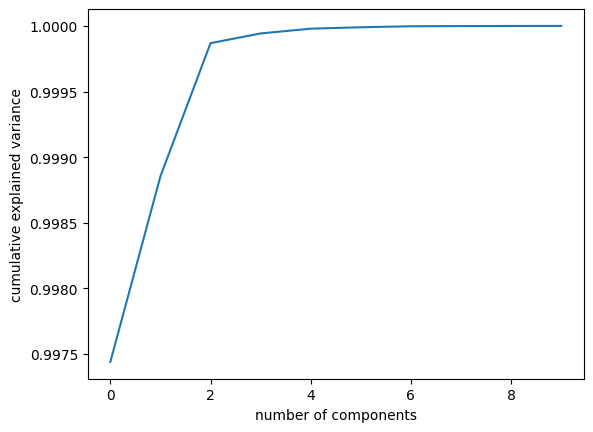

In [203]:
# determine the number of components
pca = PCA().fit(proc_img_df)
plt.plot(np.cumsum(pca.explained_variance_ratio_[:10]))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

In [204]:
def calculate_pca(feature_df, n_components):
    pca = PCA(n_components=n_components)
    reduced_feature = pca.fit_transform(feature_df)
    return reduced_feature

In [206]:
reduced_proc_img = calculate_pca(proc_img_df, 2)
reduced_proc_img

array([[-1777.65324212,   -52.52707803],
       [-1772.43041173,    92.00385062],
       [-1775.08135623,    -5.24350415],
       ...,
       [-1748.89799162,  -122.95978418],
       [-1611.13420522,   -87.80909653],
       [-1776.25091854,     9.44440651]])

In [207]:
reduced_orig_img = calculate_pca(orig_img_df, 2)
reduced_orig_img

array([[-2493.2220022 ,   -24.42096994],
       [-2527.91352738,   -29.21897968],
       [-2499.70122869,   -27.33648636],
       ...,
       [-2368.90067517,   -12.5311456 ],
       [-2140.27979457,    33.24157785],
       [-2506.53952191,   -25.27788147]])

In [220]:
def export_reduced_feature(df: Union[np.ndarray, pd.DataFrame], filename, header=None):
    if isinstance(df, np.ndarray):
        df = pd.DataFrame(df, columns=header)
    df.to_csv(os.path.join('data', f'{filename}.csv'), index=False)
    df.to_excel(os.path.join('data', 'excel', f'{filename}.xlsx'), index=False)

In [209]:
def generate_pca_header(array):
    return [f'pca_{x}' for x in range(1, array.shape[1] + 1)]

In [221]:
export_reduced_feature(reduced_proc_img,
                       'reduced_processed_img_features_PCA',
                       generate_pca_header(reduced_proc_img))
export_reduced_feature(reduced_orig_img,
                       'reduced_orig_img_features_PCA',
                       generate_pca_header(reduced_orig_img))

### Mutual Information

In [199]:
mi = mutual_info_classif(proc_img_df, proc_img_label)
mi

array([0.02522403, 0.        , 0.0145416 , 0.02522403, 0.04003607,
       0.00354859, 0.        , 0.03985551, 0.01731456, 0.03283884,
       0.01228582, 0.01731456, 0.02457991, 0.02932151, 0.01972513,
       0.02517277, 0.02461411, 0.02929329, 0.01963082, 0.02496411,
       0.02252849, 0.        , 0.        , 0.02252849, 0.00092185,
       0.00752757, 0.        , 0.        , 0.02504745, 0.02927186,
       0.01951971, 0.02504745, 0.0508528 , 0.04118271, 0.02879254,
       0.0508528 , 0.02483467, 0.02914294, 0.01972513, 0.02468884,
       0.01267314, 0.02627298, 0.        , 0.01267314, 0.014825  ,
       0.01624908, 0.        , 0.014825  , 0.01270494, 0.02357088,
       0.0404842 , 0.00369993, 0.01992307, 0.0639595 , 0.03418866,
       0.01665328, 0.00463922, 0.02674894, 0.        , 0.02116344,
       0.03162382, 0.01184386, 0.00156319, 0.02406732, 0.02249443,
       0.        , 0.00119395])

In [218]:
def calculate_mutual_information(feature_df, label, threshold=0.05):
    mi = mutual_info_classif(feature_df, label)
    selected_column_index = np.where(mi > threshold)
    return feature_df.iloc[:,  selected_column_index[0]]

In [222]:
reduced_proc_img_features_mi = calculate_mutual_information(
    proc_img_df,
    proc_img_label
)
reduced_orig_img_features_mi = calculate_mutual_information(
    orig_img_df,
    orig_img_label
)
reduced_orig_img_features_mi

,std_G
0,29.313368
1,35.670507
2,36.787138
3,27.676413
4,34.734952
...,...
1995,22.834124
1996,34.170456
1997,47.567790
1998,31.004115


In [223]:
export_reduced_feature(reduced_proc_img_features_mi, 'reduced_processed_img_features_mi')
export_reduced_feature(reduced_orig_img_features_mi, 'reduced_orig_img_features_mi')

### SelectFromModel

We are using SVM-FS. There isn't specific library for SVM-based feature selection out-of-the-box. But we can use `SelectFromModel` from scikit-learn.

In [224]:
def calculate_svmfs(feature_df: pd.DataFrame, label):
    clf = svm.SVC(kernel='linear')
    selector = SelectFromModel(clf, prefit=False)
    selector.fit(feature_df, label)
    selected_feature = selector.transform(feature_df)
    mask = np.isin(feature_df.values, selected_feature)
    index_column = np.where(np.all(mask, axis=0))
    return feature_df.iloc[:, index_column[0]]

In [226]:
reduced_proc_img_features_svmfs = calculate_svmfs(proc_img_df, proc_img_label)
reduced_orig_img_features_svmfs = calculate_svmfs(orig_img_df, orig_img_label)
reduced_proc_img_features_svmfs

,dissimilarity_45,correlation_0,correlation_45,correlation_135,entropy_0,entropy_45,entropy_90,entropy_135,skewness_0,skewness_45,skewness_90,skewness_135,skew_G,mean_B,std_B,kurt_B
0,13.893349,0.929609,0.911190,0.929609,1.549168,1.600693,1.372490,1.549168,4.129488,3.925772,5.086587,4.129488,0.443199,0.444215,-0.542365,-0.334810
1,18.372611,0.919031,0.871517,0.919031,1.658751,1.765200,1.553328,1.658751,4.105650,3.876342,5.270521,4.105650,0.364858,0.567933,-0.870588,-0.273551
2,15.681830,0.912965,0.891547,0.912965,1.599899,1.650629,1.380467,1.599899,4.075033,3.938748,4.997665,4.075033,0.195758,0.583624,-0.858512,0.122793
3,15.207228,0.892641,0.872188,0.892641,1.542649,1.582728,1.384447,1.542649,4.787381,4.652021,6.227309,4.787381,0.781244,0.642583,0.213633,0.020020
4,16.010581,0.920785,0.899190,0.920785,1.631088,1.689503,1.423965,1.631088,3.900342,3.650562,4.988013,3.900342,0.302806,0.376741,-0.748605,-0.494731
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,10.198739,0.918559,0.899513,0.918559,1.148671,1.198202,0.959392,1.148671,8.706605,8.300970,11.512865,8.706605,1.663018,2.028161,3.146776,5.743191
1996,10.895317,0.966769,0.945656,0.966769,1.284708,1.399678,1.166527,1.284708,7.846494,7.172845,9.776736,7.846494,1.172130,2.180556,0.463323,6.778908
1997,11.398631,0.957658,0.951072,0.957658,1.488816,1.529168,1.284869,1.488816,5.098042,4.821870,6.370615,5.098042,0.455577,1.522308,-0.771425,2.208251
1998,13.492180,0.933846,0.914489,0.933846,1.482984,1.529206,1.334924,1.482984,8.606598,7.960854,10.444479,8.606598,0.986377,1.263004,0.133673,1.284055


In [227]:
export_reduced_feature(reduced_proc_img_features_svmfs, 'reduced_processed_img_features_svmfs')
export_reduced_feature(reduced_orig_img_features_svmfs, 'reduced_orig_img_features_svmfs')

## Classification

In [2]:
import numpy as np
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import MinMaxScaler
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

import pandas as pd
import os
import itertools
import glob
import re
from typing import Callable

In [3]:
kernels = ['linear', 'rbf', 'poly', 'sigmoid']
metrics = ['f1', 'recall', 'precision', 'accuracy']
classifiers = ['knn', 'nb', 'rf']

In [4]:
def classify_with_svm(X: np.ndarray, y: np.ndarray, kernel: str, scoring=metrics):
    pipe = Pipeline([
        ('normalize', MinMaxScaler()),
        ('classify', svm.SVC(kernel=kernel))
    ])
    result = cross_validate(pipe, X=X, y=y, cv=10, scoring=scoring)
    return result

In [5]:
def classify(X: np.ndarray, y: np.ndarray, classifier: Callable, scoring):
    pipe = Pipeline([
        ('normalize', MinMaxScaler()),
        ('classify', classifier)
    ])
    result = cross_validate(pipe, X, y, cv=10, scoring=scoring)
    return result

### All features combination

In [6]:
def create_dataframe(all_feat_comb, classifiers):
    # create fancy multi-column table

    all_feat_comb_merged = []
    for feat in all_feat_comb:
        if isinstance(feat, str):
            all_feat_comb_merged.append(feat)
        else:
            all_feat_comb_merged.append('-'.join(feat))

    index = pd.MultiIndex.from_product([all_feat_comb_merged, metrics])
    df = pd.DataFrame([], index=classifiers, columns=index)
    return df

In [23]:
os.mkdir('result')

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'result'

In [9]:
def train_combination(all_classifiers, all_feat_comb, features, feature_df, y, comparison_df, fancy_df, use_svm=True):
    classifiers_map = {'knn': KNeighborsClassifier(3),
                       'nb': GaussianNB(),
                       'rf': RandomForestClassifier()}

    for classifier in all_classifiers:
        for feature in all_feat_comb:
            if not isinstance(feature, str):
                feat_col_name = []
                name = []
                for i in range(len(feature)):
                    feat_col_name += features[feature[i]]
                    name.append(feature[i])
                name = '-'.join(name)
            else:
                feat_col_name = features[feature]
                name = feature
            X = feature_df.loc[:, feat_col_name]
            # print(name)
            # print(X.columns, classifier)
            if use_svm:
                result = classify_with_svm(X, y, kernel=classifier)
            else:
                result = classify(X, y, classifiers_map[classifier], scoring=metrics)

            comparison_df.loc[len(comparison_df.index)] = [
                f'{name}_{classifier}',
                result['fit_time'].mean(),
                result['test_f1'].mean(),
                result['test_recall'].mean(),
                result['test_precision'].mean(),
                result['test_accuracy'].mean()
            ]
            fancy_df.loc[classifier, name] = [result['test_f1'].mean(),
                                              result['test_recall'].mean(),
                                              result['test_precision'].mean(),
                                              result['test_accuracy'].mean()]

    return comparison_df, fancy_df

In [10]:

def compare_combined_feature(filename, use_svm: bool, classifiers_or_kernels=kernels):
    columns = ['names', 'fit_time'] + metrics
    comparison_df = pd.DataFrame(columns=columns)

    feature_file = os.path.join('data', filename)
    feature_df = pd.read_csv(feature_file)
    y = feature_df.pop('is_infected')

    features = {'texture': feature_df.columns[:49].to_list(),
                'color': feature_df.columns[49:61].to_list(),
                'shape': feature_df.columns[61:].to_list()}
    all_feat_comb = list(features.keys())
    all_feat_comb += list(itertools.combinations(all_feat_comb, 2))
    all_feat_comb += [tuple(features.keys())]

    fancy_df = create_dataframe(all_feat_comb, classifiers_or_kernels)

    comparison_df, fancy_df = train_combination(classifiers_or_kernels, all_feat_comb,
                                                features, feature_df, y,
                                                comparison_df, fancy_df, use_svm=use_svm)

    # export basic dataframe to csv
    if use_svm:
        export_name = os.path.join('result', filename.split('_')[0] + '_classification_result')
    else:
        export_name = os.path.join('result', filename.split('_')[0] + '_classfication_classifiers_result')
    comparison_df.to_csv(export_name + '.csv', index=False)
    # export fancy dataframe to excel
    fancy_df.to_excel(export_name + '.xlsx')

    comparison_df.set_index('names').iloc[:, 1:]\
        .plot\
        .bar(figsize=(17, 7), title='Metrics comparison (higher better)')

    return comparison_df

#### SVM Kernels

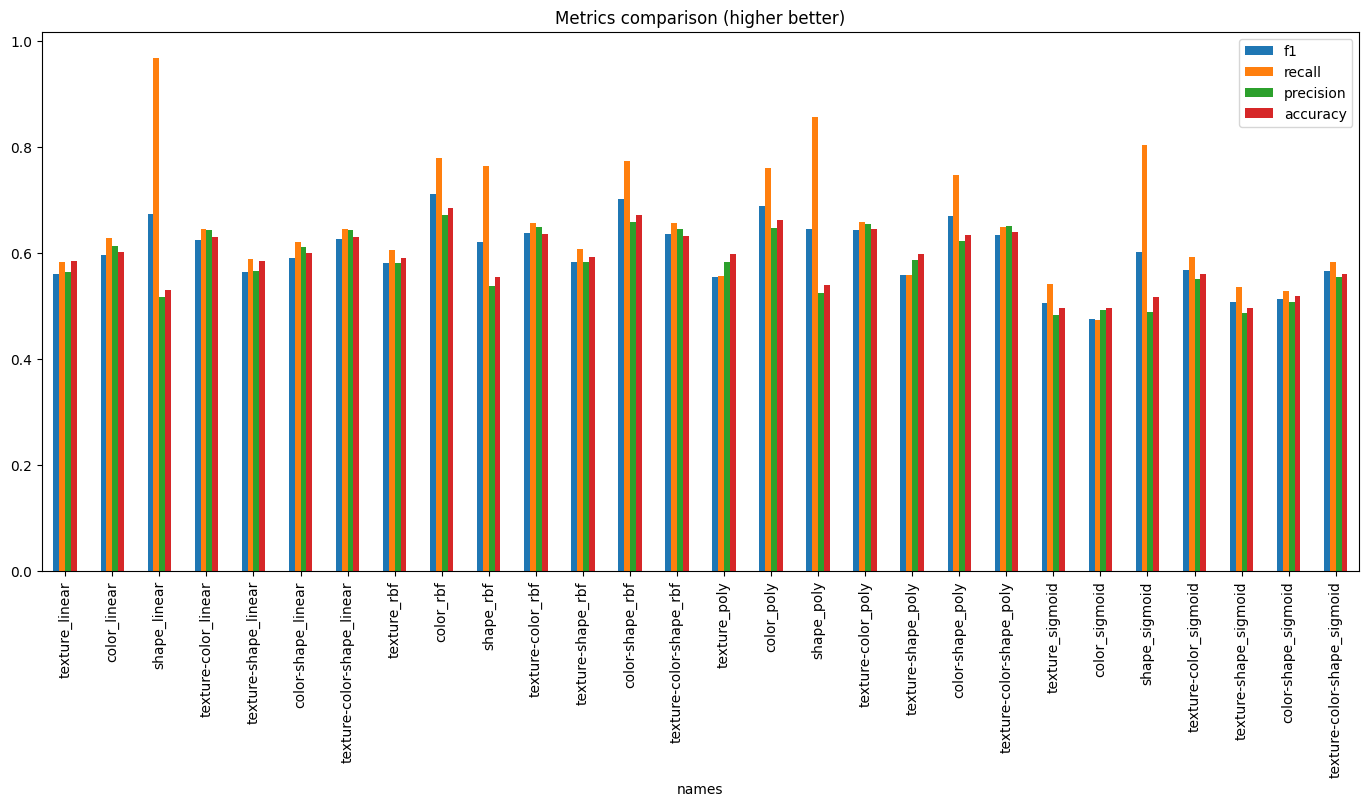

In [11]:
orig_img_compare_df = compare_combined_feature('orig_img_feature.csv', use_svm=True)

<Axes: title={'center': 'Fit Time (lower better)'}, xlabel='names'>

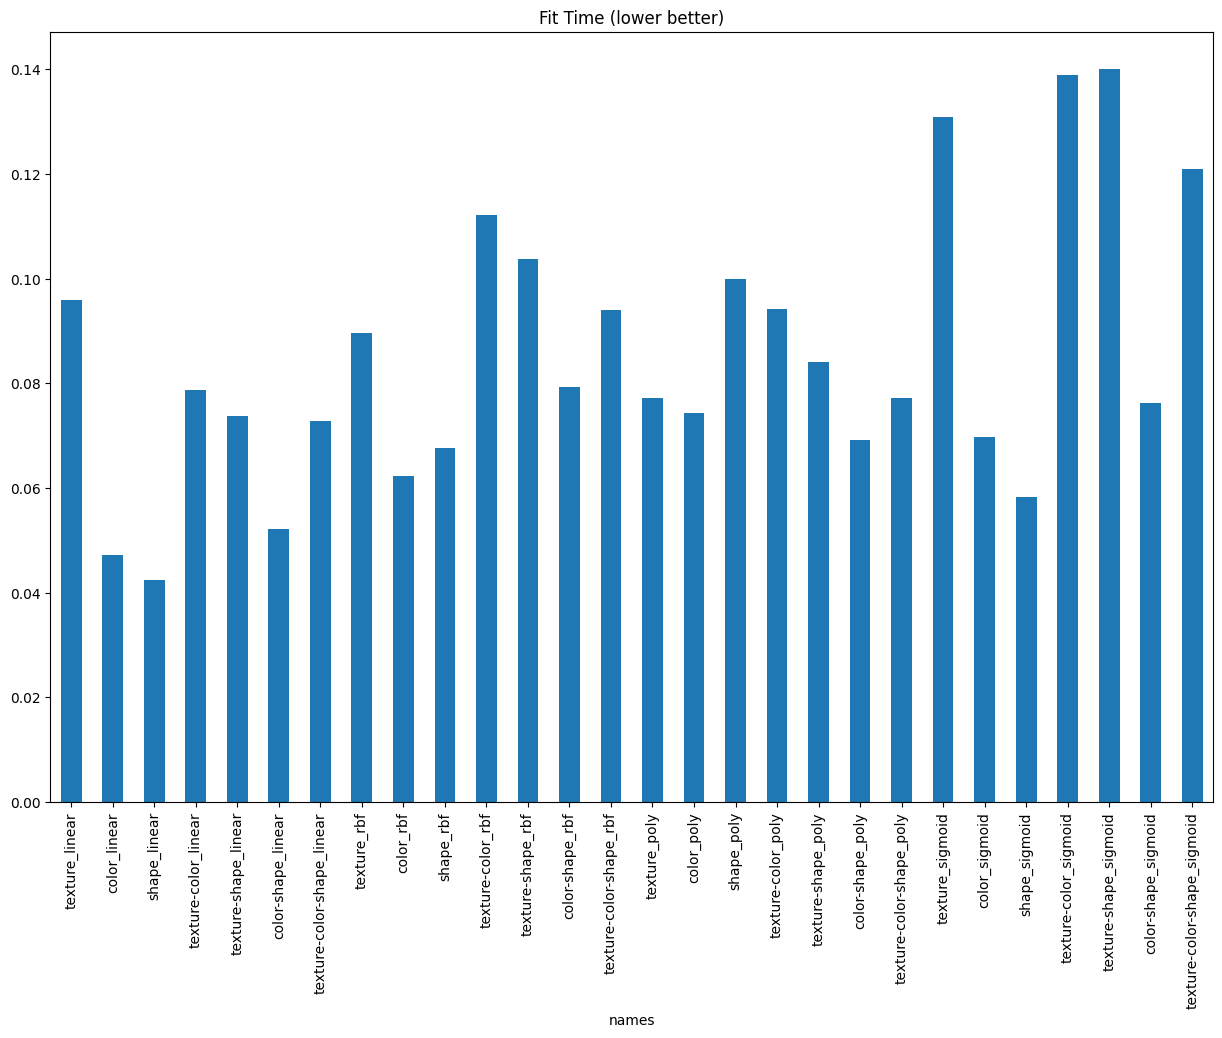

In [12]:
orig_img_compare_df.set_index('names').iloc[:, 0].plot.bar(figsize=(15, 10), title='Fit Time (lower better)')

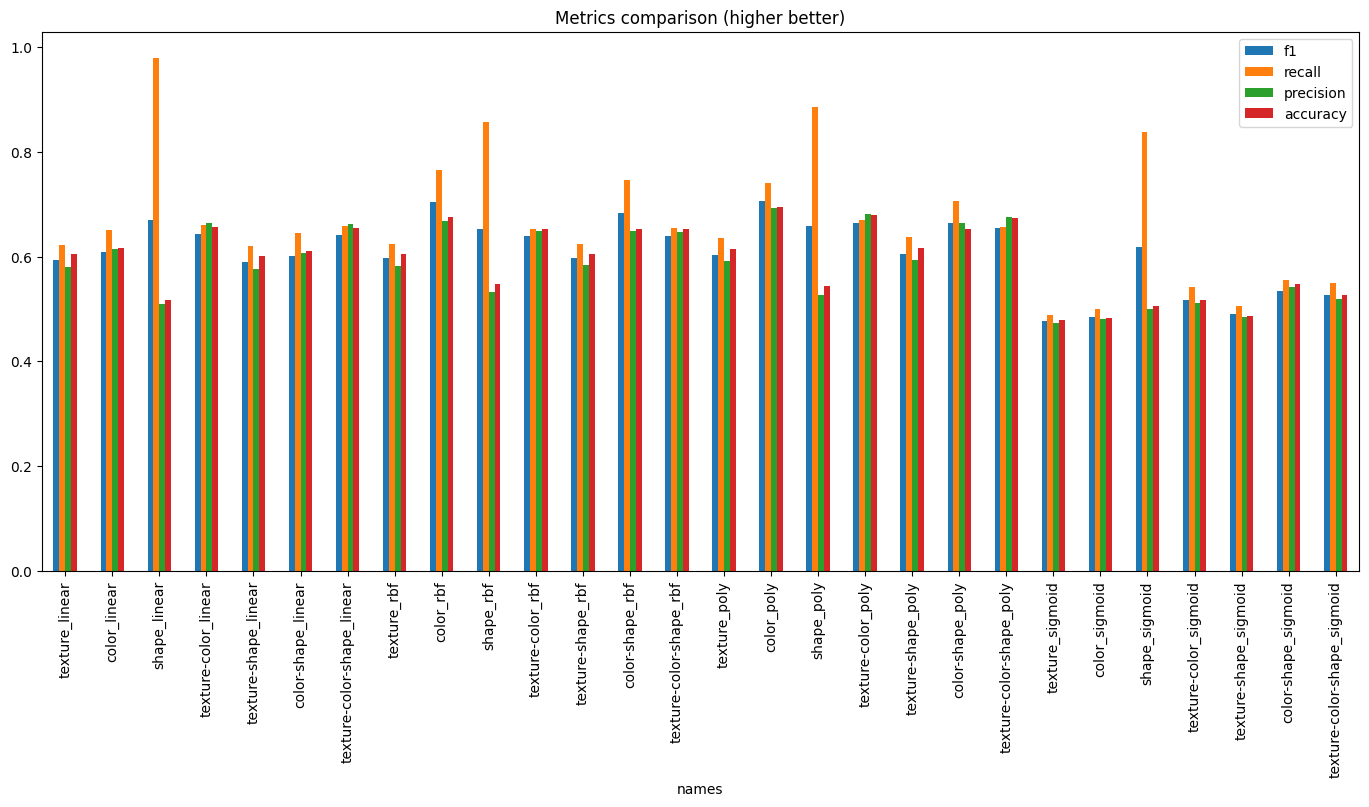

In [13]:
proc_img_compare_df = compare_combined_feature('processed_img_feature.csv', use_svm=True)

<Axes: title={'center': 'Fit Time (lower better'}, xlabel='names'>

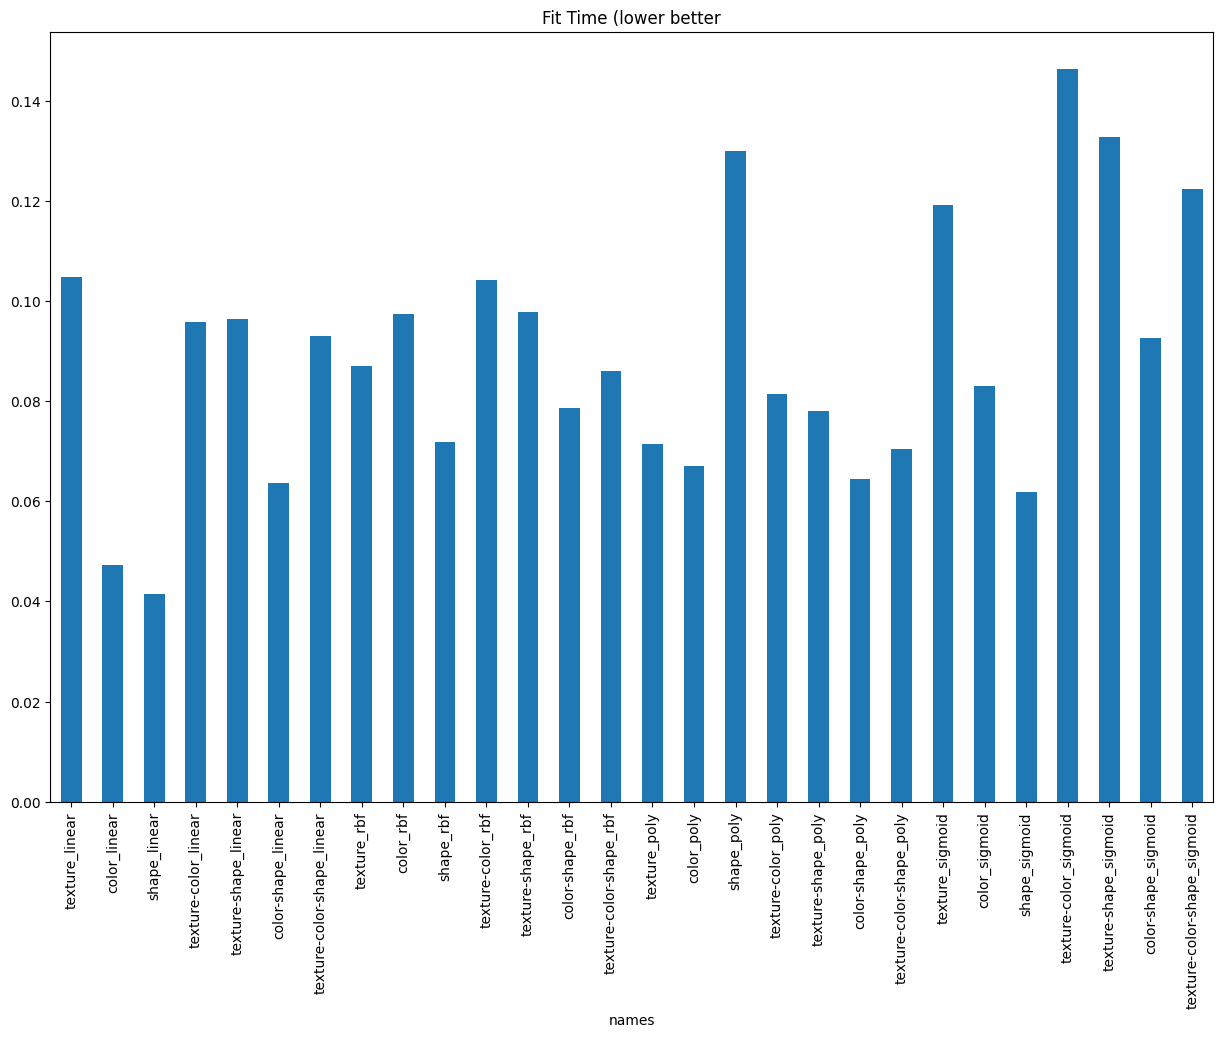

In [14]:
proc_img_compare_df.set_index('names').iloc[:, 0].plot.bar(figsize=(15, 10), title='Fit Time (lower better')

#### Another Classifiers

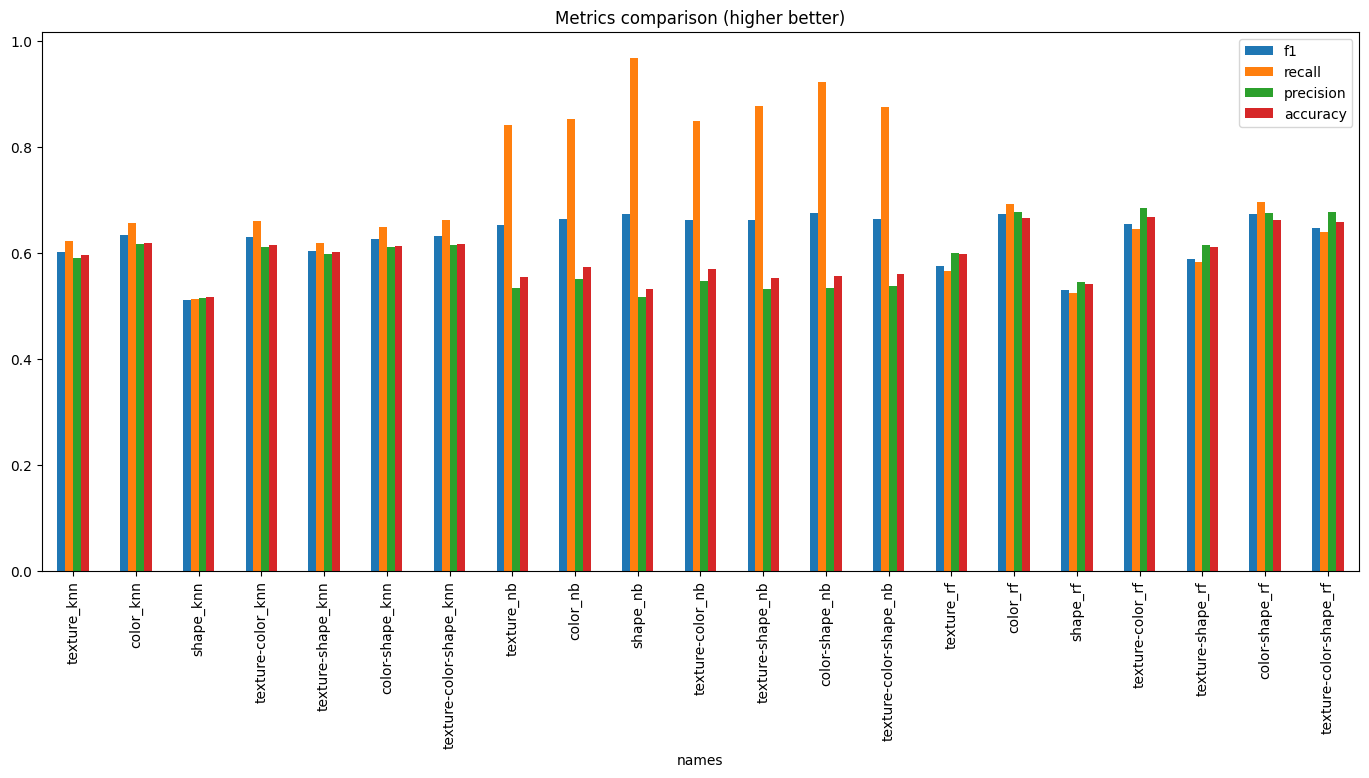

In [15]:
orig_img_classifier_compare_df = compare_combined_feature('orig_img_feature.csv', use_svm=False, classifiers_or_kernels=classifiers)

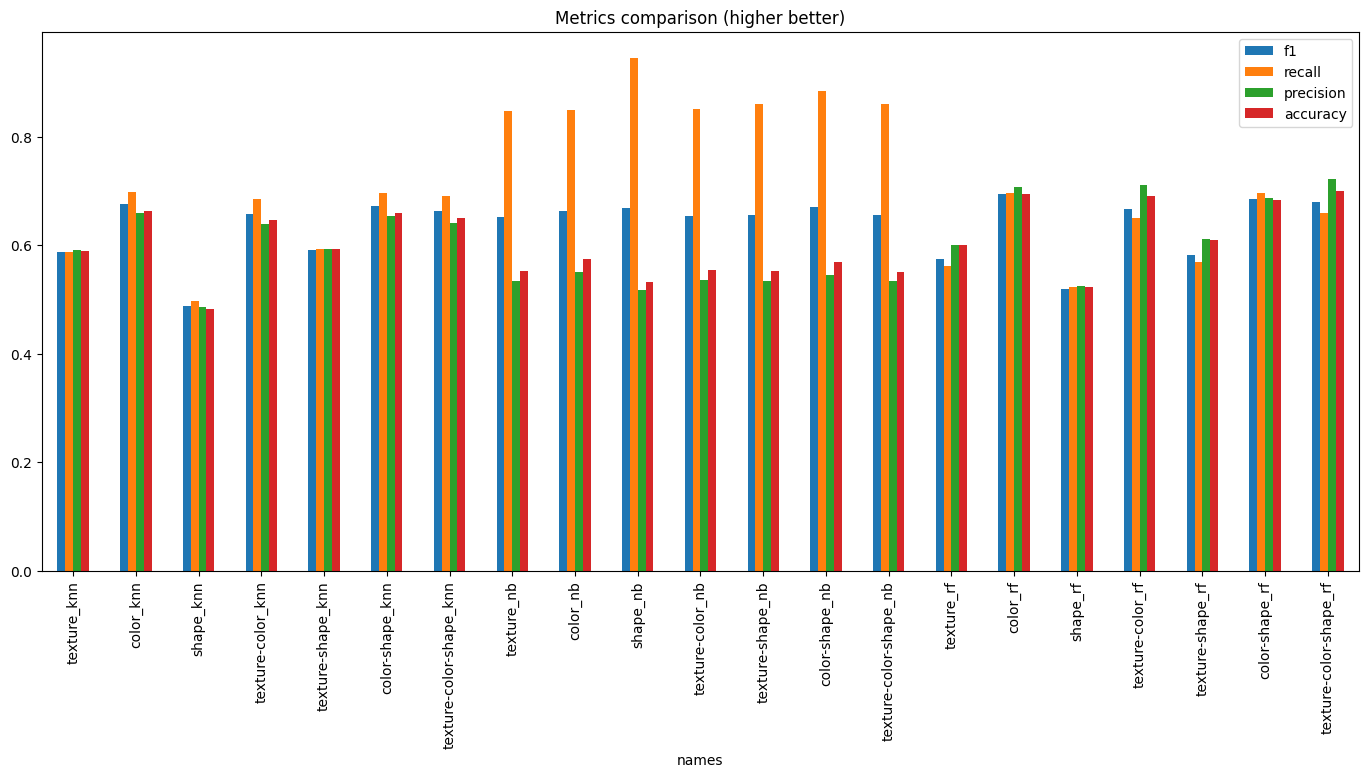

In [16]:
proc_img_compare_df = compare_combined_feature('processed_img_feature.csv', use_svm=False, classifiers_or_kernels=classifiers)

### Reduced Feature

In [17]:
def train_reduced(all_classifiers, feature_files, y, comparison_df, fancy_df, use_svm=True):
    classifiers_map = {'knn': KNeighborsClassifier(3),
                       'nb': GaussianNB(),
                       'rf': RandomForestClassifier()}

    for classifier in all_classifiers:
        for feature_file in feature_files:
            X = pd.read_csv(feature_file)
            name = re.findall(r"s_(.*)\.csv", feature_file)[0].upper()
            if use_svm:
                result = classify_with_svm(X, y, kernel=classifier)
            else:
                result = classify(X, y, classifiers_map[classifier], scoring=metrics)
            comparison_df.loc[len(comparison_df.index)] = [f'{name}_{classifier}',
                                                           result['fit_time'].mean(),
                                                           result['test_f1'].mean(),
                                                           result['test_recall'].mean(),
                                                           result['test_precision'].mean(),
                                                           result['test_accuracy'].mean()]
            fancy_df.loc[classifier, name] = [result['test_f1'].mean(),
                                              result['test_recall'].mean(),
                                              result['test_precision'].mean(),
                                              result['test_accuracy'].mean()]

    return comparison_df, fancy_df

In [18]:
def compare_reduced_feature(csv_file_pattern, use_svm: bool, classifiers_or_kernels=kernels):
    feature_files = glob.glob(os.path.join('data', csv_file_pattern))
    comparison_df = pd.DataFrame(columns=['names', 'fit_time'] + metrics)
    y = pd.read_csv(os.path.join('data', 'orig_img_feature.csv'), usecols=['is_infected']).values.ravel()

    all_feat_sel = [re.findall(r's_(.*)\.csv', x)[0].upper() for x in feature_files]
    fancy_df = create_dataframe(all_feat_sel, classifiers_or_kernels)

    comparison_df, fancy_df = train_reduced(classifiers_or_kernels, feature_files,
                                            y, comparison_df, fancy_df, use_svm=use_svm)

    if use_svm:
        filename = '_classification_result'
    else:
        filename = '_classification_classifiers_result'
    export_name = csv_file_pattern.replace('*', '').replace('.csv', filename)
    export_name = os.path.join('result', export_name)
    # export basic dataframe to csv
    comparison_df.to_csv(export_name + '.csv', index=False)
    # export fancy dataframe to excel
    fancy_df.to_excel(export_name + '.xlsx')

    comparison_df.set_index('names').iloc[:, 1:].plot.bar(figsize=(17, 7), title='Metrics comparison (higher better)')

    return comparison_df

#### Another Classifiers

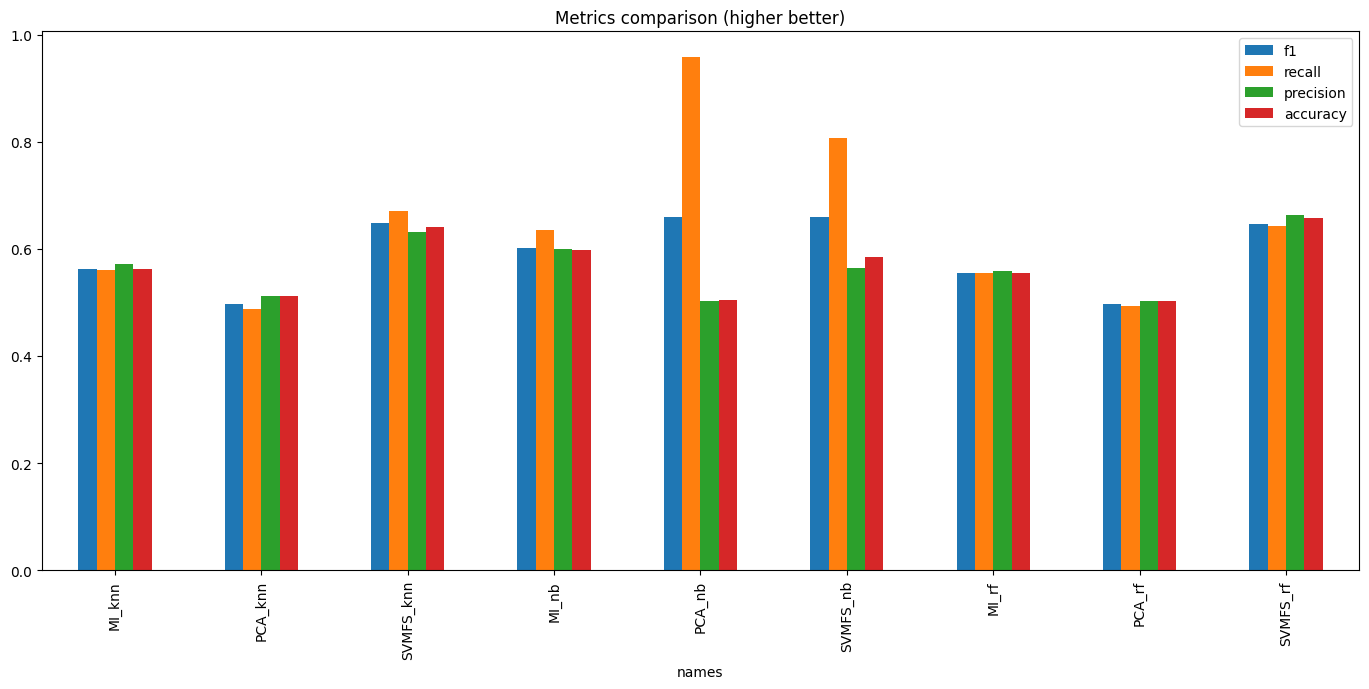

In [19]:
red_orig_compare_classifiers_df = compare_reduced_feature('reduced_*orig*.csv', use_svm=False, classifiers_or_kernels=classifiers)

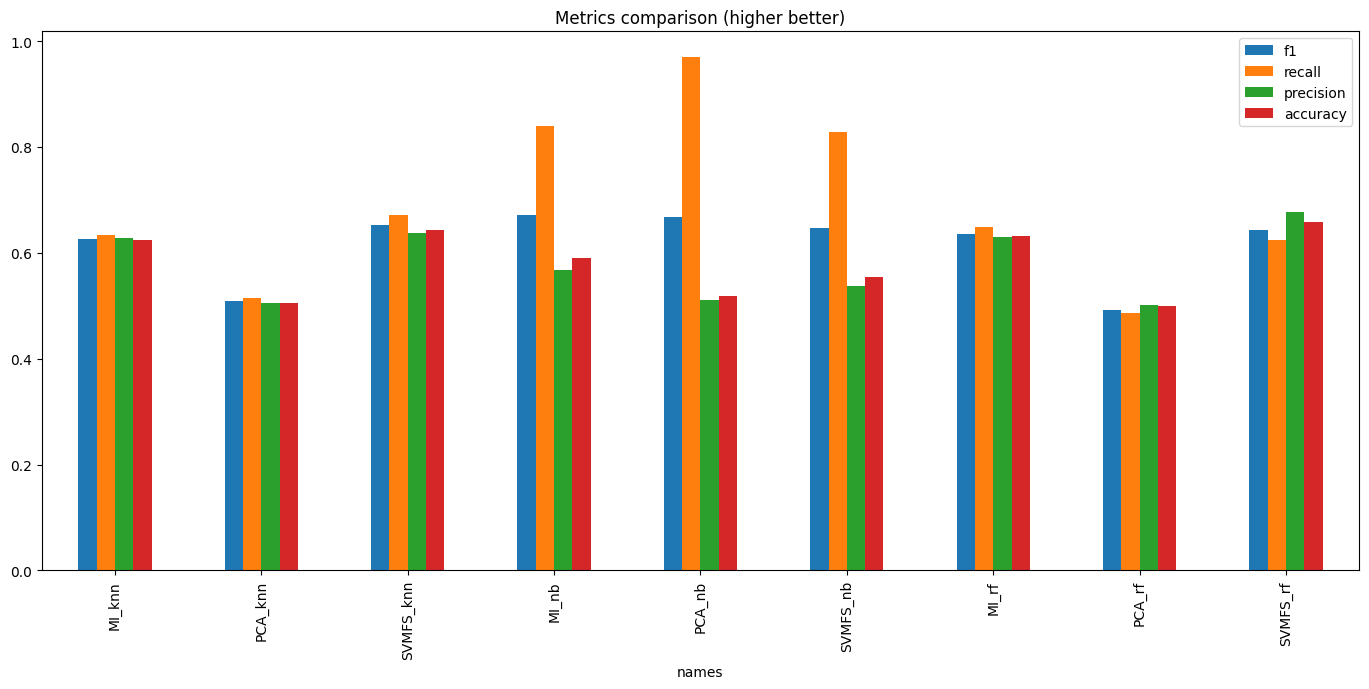

In [20]:
red_proc_compare_classifiers_df = compare_reduced_feature('reduced_*proc*.csv', use_svm=False, classifiers_or_kernels=classifiers)

#### SVM Kernels

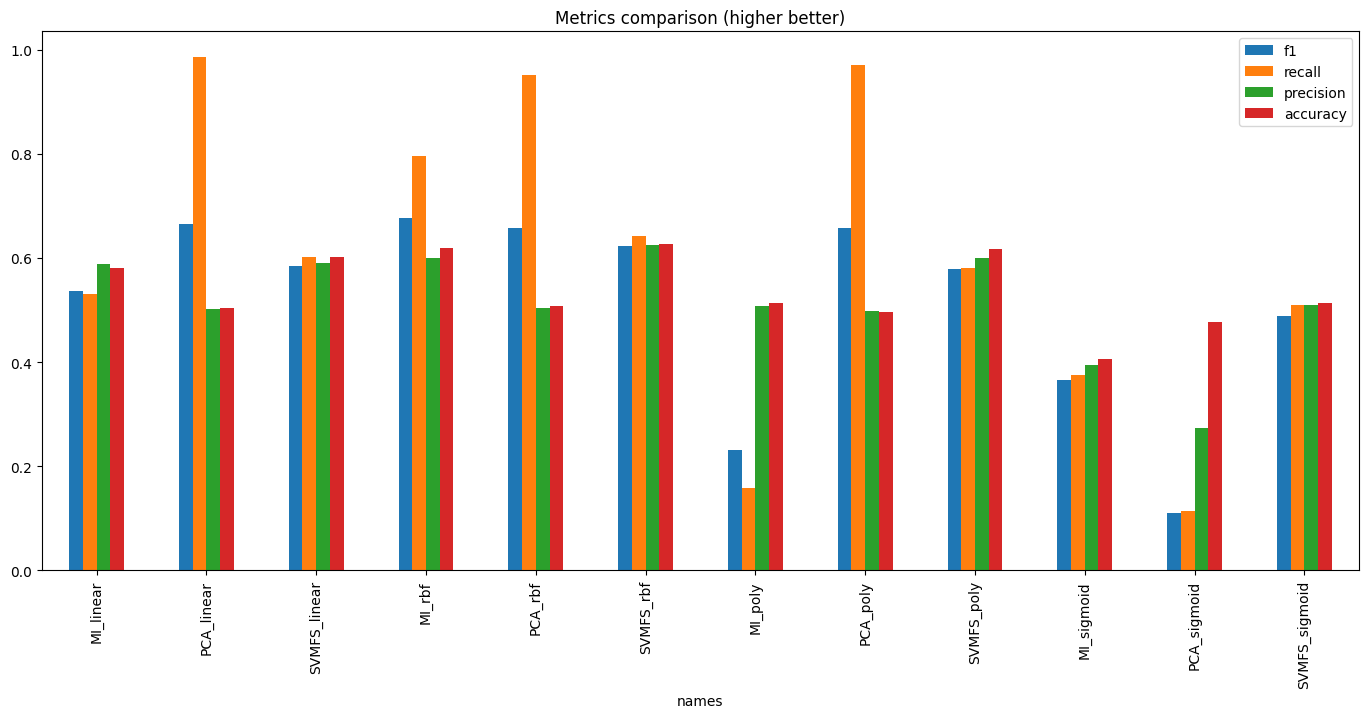

In [21]:
red_orig_compare_df = compare_reduced_feature('reduced_*orig*.csv', use_svm=True)

<Axes: title={'center': 'Fit Time (lower better'}, xlabel='names'>

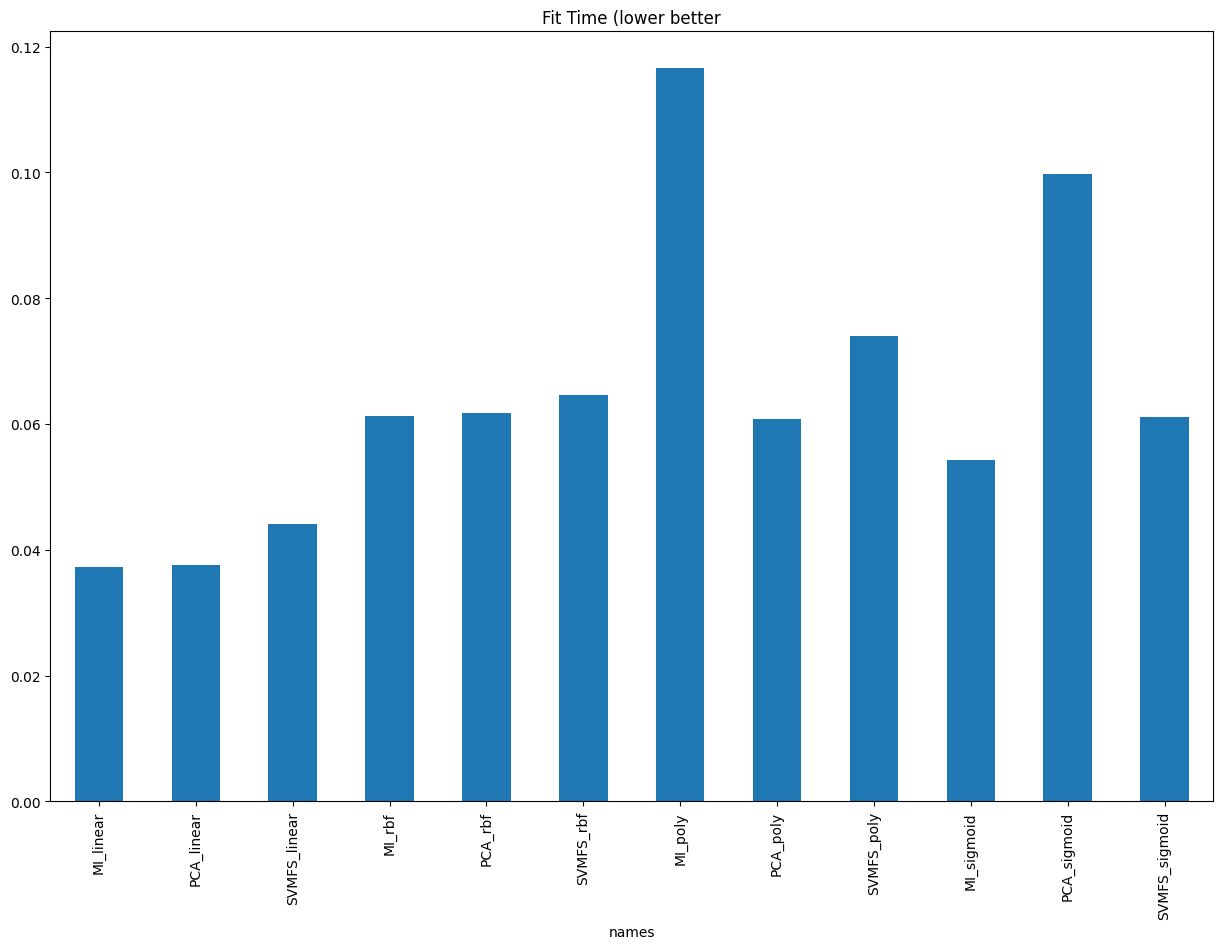

In [22]:
red_orig_compare_df.set_index('names').iloc[:, 0].plot.bar(figsize=(15, 10), title='Fit Time (lower better')

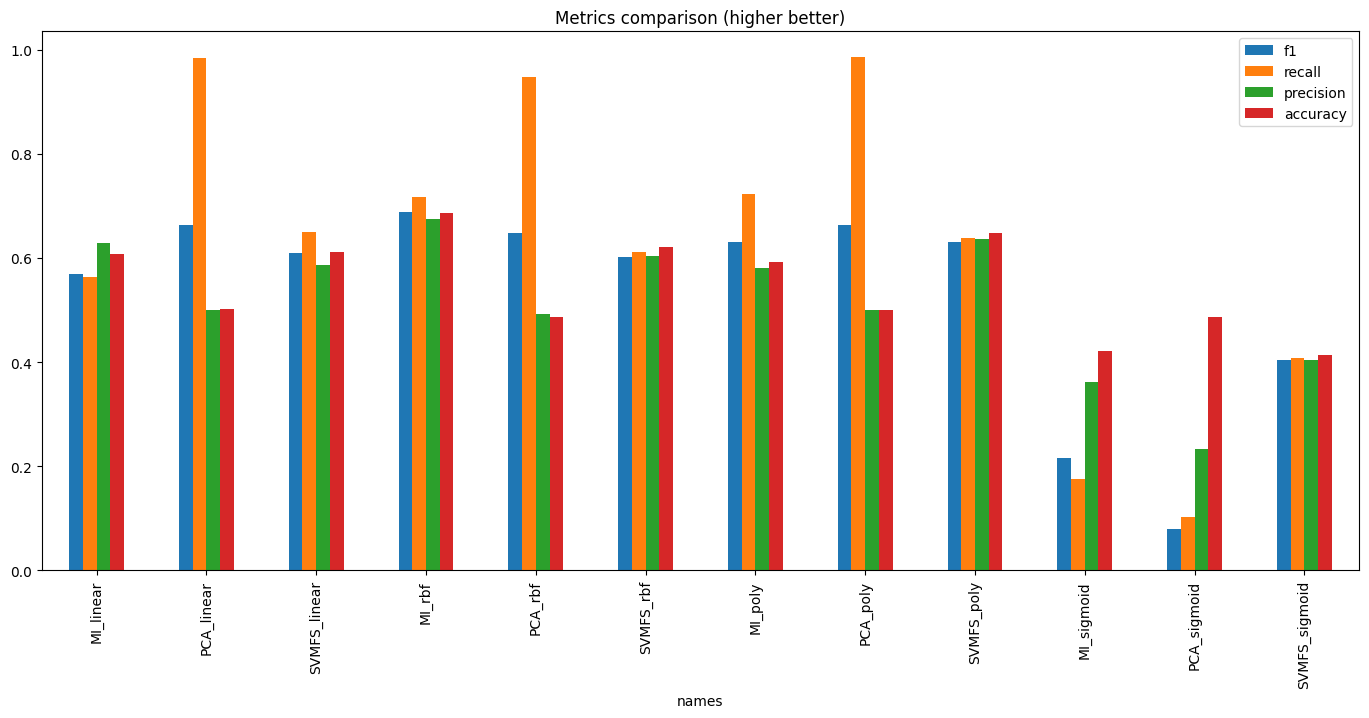

In [23]:
red_proc_compare_df = compare_reduced_feature('reduced_*proc*.csv', use_svm=True)

<Axes: title={'center': 'Fit Time (lower better'}, xlabel='names'>

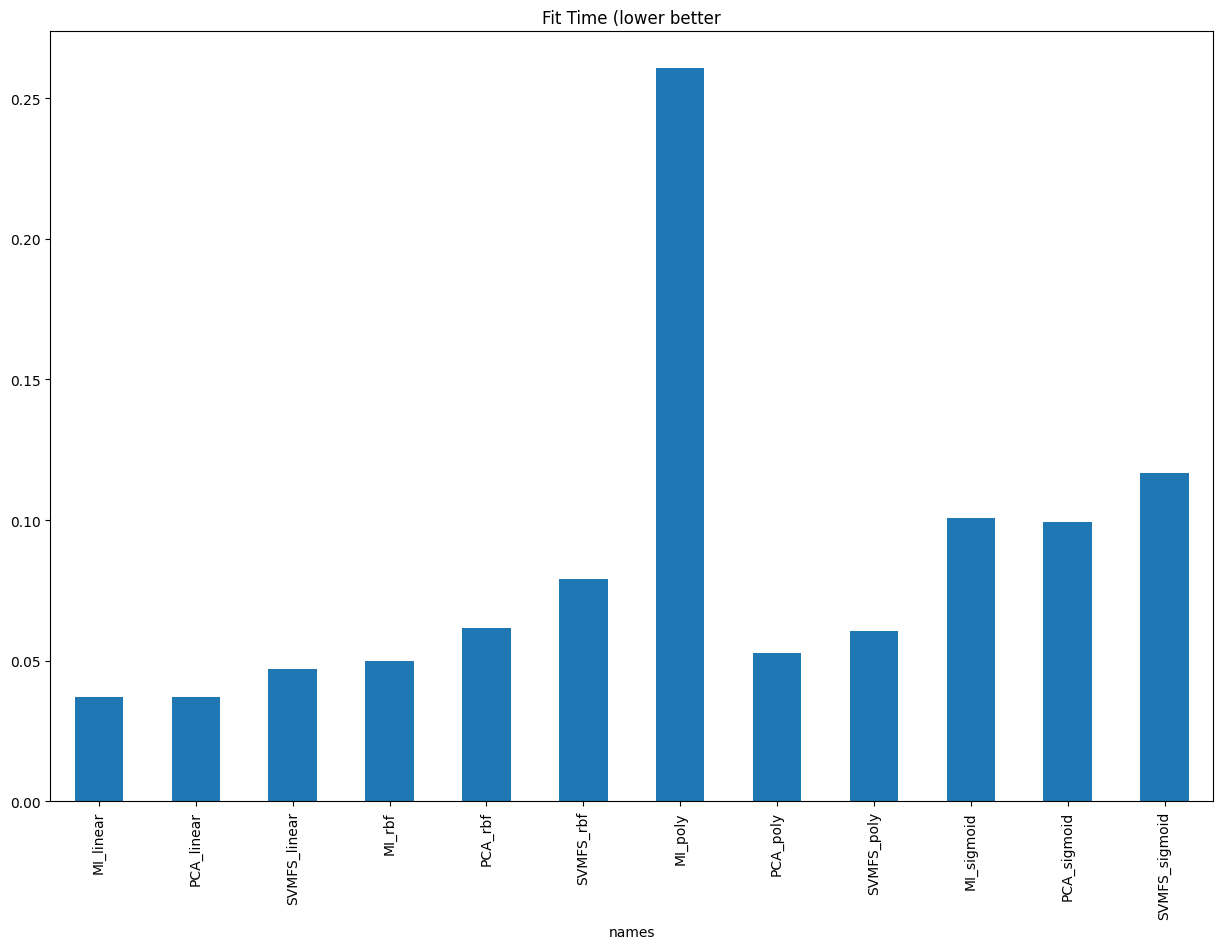

In [24]:
red_proc_compare_df.set_index('names').iloc[:, 0].plot.bar(figsize=(15, 10), title='Fit Time (lower better')

In [115]:
red_orig_compare_df

,names,fit_time,f1,recall,precision,accuracy
0,mi_linear,0.053205,0.550793,0.554,0.594520,0.5835
1,pca_linear,0.062302,0.578644,0.590,0.579827,0.5725
2,svmfs_linear,0.041339,0.546661,0.553,0.596315,0.5765
3,mi_rbf,0.066100,0.651582,0.740,0.599089,0.6045
4,pca_rbf,0.063999,0.610626,0.629,0.602788,0.6055
5,svmfs_rbf,0.060600,0.653990,0.728,0.611271,0.6150
6,mi_poly,0.058200,0.653319,0.777,0.577450,0.5885
7,pca_poly,0.494300,0.581137,0.600,0.571852,0.5690
8,svmfs_poly,0.073802,0.475871,0.518,0.511354,0.5240
9,mi_sigmoid,0.061400,0.495395,0.500,0.495920,0.5000
